In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)
# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

import seaborn as sns
from scipy.signal import savgol_filter

from ssa_calc import Satellite
from astropy.time import Time
import astropy.units as u

2023-06-26 11:49:30.791018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 11:49:32.632268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-26 11:49:32.632403: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-26 11:49:32.632416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  1


In [2]:
def normalize_temperature(temps, limits=None):
    """
    Function to normalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be normalized.
    :param limits: Limits of the temperature data. If None, the limits are calculated from the data.

    :return: Normalized temperature data.
    """
    
    if limits is None:
        limits = np.array([np.min(temps), np.max(temps)])

    return (temps - limits[0]) / (limits[1] - limits[0])

def denormalize_temperature(temps, limits):
    """
    Function to denormalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be denormalized.
    :param limits: Limits of the temperature data.

    :return: Denormalized temperature data.
    """

    return temps * (limits[1] - limits[0]) + limits[0]

In [3]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, labels=None, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param bins: Number of bins to be used for the KDE.
    :param plot_kde: Boolean to plot the KDE.
    :param labels: Labels of the KDE plots.

    :return: kde, bin_centers
    """

    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the KDE values
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the bin centers
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])  # kernel density estimate function
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)  # bin centers
        kde[i, :] = kde_func(bin_centers[i])    # KDE values

    if plot_kde:
        plt.figure(figsize=(6, 5), tight_layout=True)
        for i in range(data.shape[1]):
            plt.plot(
                bin_centers[i],
                kde[i],
                color=plt_colors[i],
                label=labels[i] if labels is not None else None,
            )

        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density ($^\circ$C$^{-1}$)")
        if plt_title is None:
            plt_title = "Kernel density estimate of the errors"
        plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    return kde, bin_centers



def print_kde_stats(data, kde, bin_centers):
    """
    Function to print the mean, standard deviation and area under the KDE curve of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param kde: KDE values.
    :param bin_centers: Bin centers.

    :return: None
    """

    print("Battery:")
    print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
    print("Solar panel Yp:")
    print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
    print("Solar panel Ym:")
    print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
    print("Solar panel Xp:")
    print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
    print("Solar panel Xm:")
    print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
    print("MCU:")
    print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")


In [4]:
def plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=None,
    labels=None,
    colors=None,
    plt_scatter=None,
    linestyles=None,
    limits=None,
    plt_suptitle=None,
):
    """Plots the temperature values of the model.

    Parameters
    ----------
    theta_T_vals : list of numpy.ndarray
        List of theta_T values for each model.
    temp_vals : list of numpy.ndarray
        List of temperature values for each model.
    plt_titles : list of str, optional
        List of titles for each subplot, by default None
    labels : list of str, optional
        List of labels for each model, by default None
    colors : list of mpl colors, optional
        List of colors for each model, by default None
    plt_scatter : list of bool, optional
        List of bools to indicate if the model should be plotted as a scatter plot, by default None
    linestyles : list of str, optional
        List of linestyles for each model, by default None
    limits : list of list of float, optional
        List of limits for each axis, by default None
    plt_suptitle : str, optional
        Title for the figure, by default None
    """

    plt_rows = 2
    plt_cols = 3

    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols * 5, plt_rows * 5))

    for i in range(plt_rows):
        for j in range(plt_cols):
            for k in range(len(theta_T_vals)):
                if plt_scatter[k]:
                    ax[i, j].scatter(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        s=2,
                    )
                else:
                    ax[i, j].plot(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        linestyle=linestyles[k] if linestyles is not None else "-",
                    )

            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * plt_cols + j] if plt_titles is not None else None)
            ax[i, j].legend(fontsize=8)
            if limits is not None:
                ax[i, j].set_xlim(limits[0])
                ax[i, j].set_ylim(limits[1])

            ax[i, j].grid()

    if plt_suptitle is not None:
        fig.suptitle(plt_suptitle, fontsize=12)

    return fig, ax

In [5]:
class Model:
    """
    Class to hold the model and its training and testing data.

    :param train_x: Training input data.
    :param train_y: Training output data.
    :param test_x: Testing input data.
    :param test_y: Testing output data.
    :param name: Name of the model.
    :param model: Tensorflow model.
    :param run_device: Device to run the model on.
    :param history: History of the model training.
    """

    def __init__(self, train_x, train_y, test_x, test_y, name=None):
        """
        Initialize the model class.
        :param train_x: Training input data.
        :param train_y: Training output data.
        :param test_x: Testing input data.
        :param test_y: Testing output data.
        :param name: Name of the model.

        :return: None
        """

        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.name = name
        self.model = None
        self.run_device = None
        self.history = None


    def create_model(self, layers, optimizer, loss, metrics, input_shape, output_shape):
        """
        Create the model.
        :param layers: List of layers stored as dictionaries with the following keys: type, units, activation.
        :param optimizer: Optimizer function to use for trining.
        :param loss: Loss function to use for training.
        :param metrics: Metrics to use for training.
        :param input_shape: Shape of the input data.
        :param output_shape: Shape of the output data.

        :return: None
        """

        self.model = tf.keras.Sequential(name=self.name)    # create the model
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))   # add the input layer
        self.run_device = "/GPU:0"  # set the device to run the model on

        # Add the layers to the model
        for i, layer in enumerate(layers):
            if layer.get("type") == "LSTM":
                if i < len(layers) - 1:
                    if layers[i + 1].get("type") == "LSTM":
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=True,
                            )
                        )
                    else:
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=False,
                            )
                        )
                else:
                    self.model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
                if layer.get("activation") == "relu":
                    self.run_device = "/CPU:0"  # if the model uses a ReLU activation function, run it on the CPU
            elif layer.get("type") == "Dense":
                self.model.add(
                    tf.keras.layers.Dense(
                        layer.get("units"), activation=layer.get("activation"),
                    )
                )
            else:
                raise ValueError("Invalid layer type")  # raise an error if the layer type is invalid

        self.model.add(tf.keras.layers.Dense(output_shape, activation="linear"))    # add the output layer

        # Compile the model
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metrics],
        )

    
    def train_model(self, epochs, callbacks=None, batch_size=100, plot_train_history=True, verbose=True, monitor_val_loss=True):
        """
        Function to train the model.
        :param epochs: Number of epochs to train the model for.
        :param callbacks: Callbacks to use during training.

        :return: None
        """
        # if self.test_x is None or self.test_y is None:
        #     monitor_val_loss = False
        # else:
        #     monitor_val_loss = True
        # Train the model
        with tf.device(self.run_device):
            if monitor_val_loss:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(self.test_x, self.test_y),
                    callbacks=[callbacks],
                    verbose=verbose,
                )
            else:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                )

        # Plot the training history
        if plot_train_history:
            plt.figure(figsize=(5, 5))
            plt.plot(
                np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                self.history.history["loss"],
                color=plt_colors[0],
                label="Training Loss",
            )
            if monitor_val_loss:
                plt.plot(
                    np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                    self.history.history["val_loss"],
                    color=plt_colors[1],
                    label="Validation Loss",
                )
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(self.name)
            plt.legend()
            plt.grid()
            plt.show()

In [6]:
# Loading the data
telem_path = r"../../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2023-02-01.h5"
telem_raw_df = pd.read_hdf(
    telem_path,
    "telem",
)

telem_raw_df.head()

,time (utc),time (jd),beta (deg),fe,theta (deg),theta_T (deg),battery GG temperature (deg C),battery TMP20 temperature (deg C),solar panel Yp temperature (deg C),solar panel Ym temperature (deg C),solar panel Xp temperature (deg C),solar panel Xm temperature (deg C),MCU temperature (deg C)
0,2022-01-18 17:12:17.000,2.459598e+06,32.895989,0.349273,220.506984,337.637846,-4.2,-3.2,-24.7,-26.4,-25.0,-23.4,-12.2
1,2022-01-18 18:41:24.000,2.459598e+06,32.900397,0.349014,197.714357,314.891798,-0.7,0.8,-18.5,-20.7,-18.6,-17.8,-7.4
2,2022-01-18 18:43:24.000,2.459598e+06,32.901143,0.349090,205.275916,322.439748,-1.9,0.0,-20.9,-22.7,-20.8,-19.9,-8.9
3,2022-01-18 18:44:24.000,2.459598e+06,32.901391,0.349131,209.056697,326.213181,-2.4,-0.2,-21.9,-23.8,-22.1,-20.9,-9.8
4,2022-01-18 18:45:24.000,2.459598e+06,32.901552,0.349173,212.837490,329.986271,-3.0,-1.3,-23.0,-24.9,-23.2,-21.9,-11.2


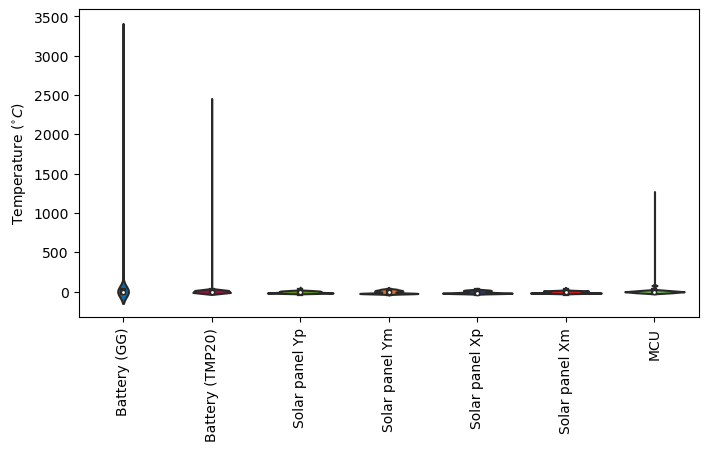

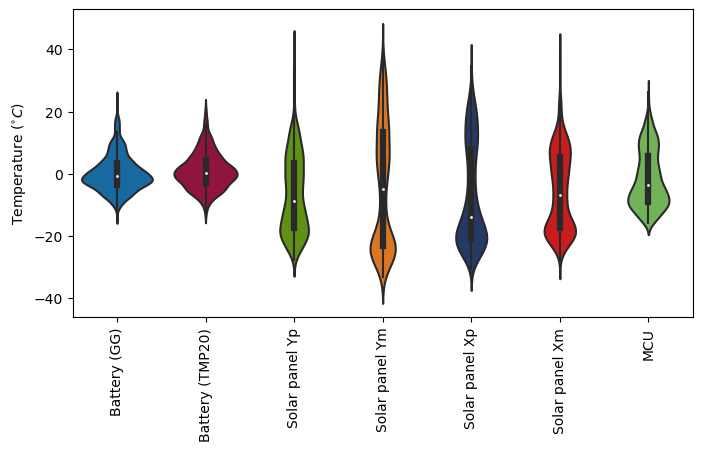

In [7]:
# Plotting the temperature data in a violin plot:
plt.figure(figsize=(8, 4))
ax = sns.violinplot(data=telem_raw_df.iloc[:, 6:], palette=plt_colors[0:7])
ax.set_ylabel("Temperature $(^{\circ}C)$")
_ = ax.set_xticklabels(["Battery (GG)", "Battery (TMP20)", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"], rotation=90)
plt.show()

# Removing obvious anomalies:
telem_df = telem_raw_df.copy(deep=True)
for i, row in telem_df.iterrows():
    for j, item in row.iloc[6:].items():
        if not -40 < item < 70:
            telem_df.loc[i, j] = np.nan
            
telem_df = telem_df.dropna(how="any")
telem_df = telem_df.iloc[1:, :]

# Plotting the temperature data in a violin plot:
plt.figure(figsize=(8, 4))
ax = sns.violinplot(data=telem_df.iloc[:, 6:], palette=plt_colors[0:7])
ax.set_ylabel("Temperature $(^{\circ}C)$")
_ = ax.set_xticklabels(["Battery (GG)", "Battery (TMP20)", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"], rotation=90)
plt.show()

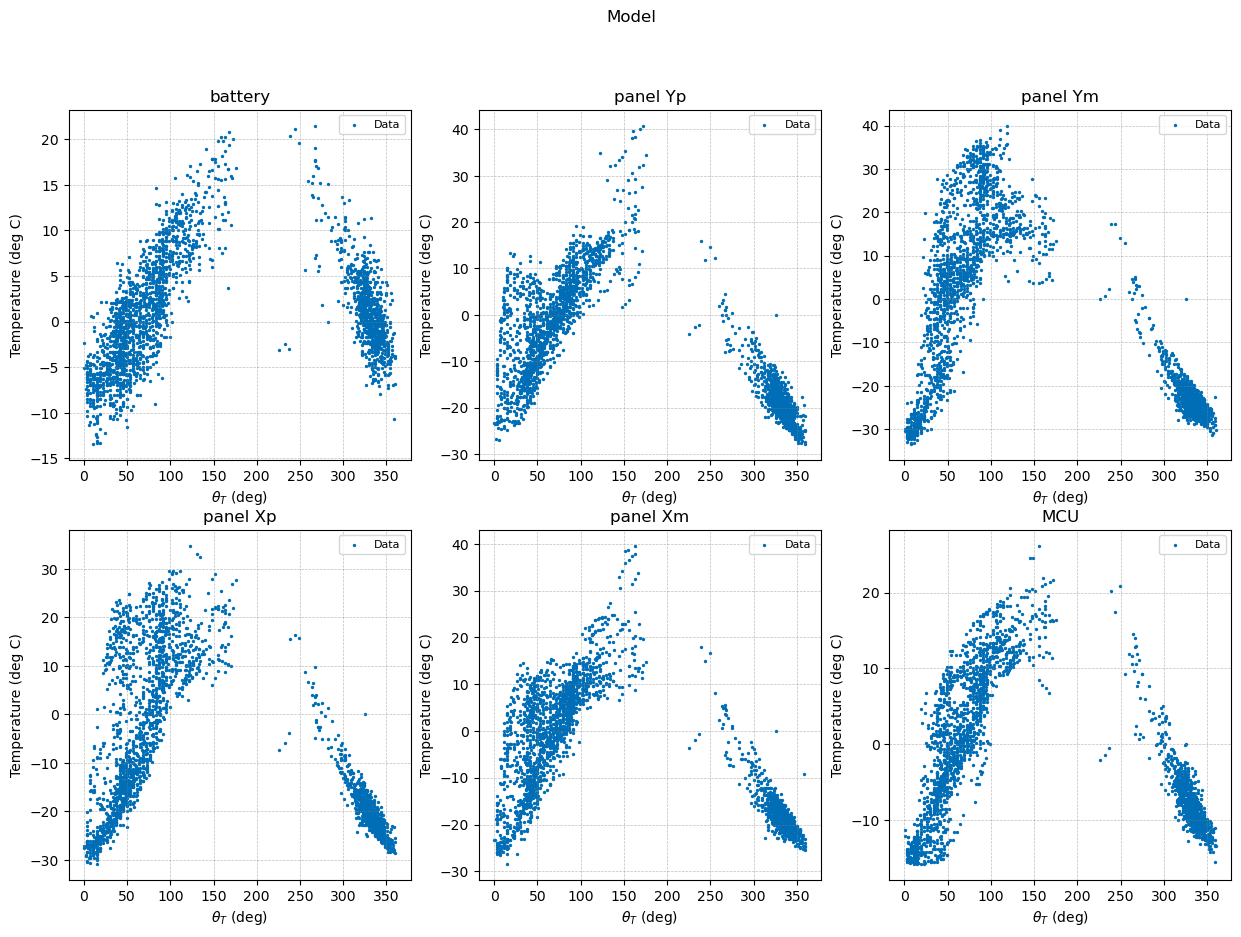

In [8]:
theta_T_vals = [telem_df["theta_T (deg)"]]
temp_vals = [telem_df.iloc[:, -6:].to_numpy()]

plt_titles = ["battery", "panel Yp", "panel Ym", "panel Xp", "panel Xm", "MCU"]
fig, ax = plot_model(theta_T_vals, temp_vals, plt_suptitle="Model", plt_scatter=[True], plt_titles=plt_titles, labels=["Data"])

In [9]:
def hampel_filter(data):
    data = data.copy()
    median = np.median(data)
    MAD = np.median(np.abs(data - median))
    HI = (data - median) / (1.4826 * MAD)
    data[HI > 3] = np.nan
    
    return data

In [10]:

illumination_data = np.load(r"./illumination_data.npy")
illumination_data = illumination_data[1:]

In [11]:

theta_T_window = 5
min_data = 7
telem_processed_df = telem_df.copy(deep=True).reset_index(drop=True)
theta_T_bins = np.arange(0, 360, theta_T_window)
theta_T = telem_processed_df["theta_T (deg)"].to_numpy()

for i in range(7):
    raw_temps = telem_processed_df.iloc[:, 6+i].to_numpy()
    cleaned_temps = raw_temps.copy()
    for theta_T_bin in theta_T_bins:
        idxs = np.where((theta_T >= theta_T_bin) & (theta_T < theta_T_bin + theta_T_window))[0]
        temps = raw_temps[idxs]
        if temps.shape[0] < min_data:
            temps[:] = np.nan
        else:
            temps = hampel_filter(temps)
        cleaned_temps[idxs] = temps
        
    telem_processed_df.iloc[:, 6+i] = cleaned_temps
    
print(telem_processed_df.shape)
print(illumination_data.shape)
# Get indexes of rows containing NaNs
nan_idxs = telem_processed_df.index[telem_processed_df.isna().any(axis=1)].tolist()
# Drop rows containing NaNs and the corresponding illumination data
telem_processed_df = telem_processed_df.dropna(how="any")
illumination_data = np.delete(illumination_data, nan_idxs, axis=0)

print(telem_processed_df.shape)
print(illumination_data.shape)
    

(2486, 13)
(2486, 120)
(2106, 13)
(2106, 120)


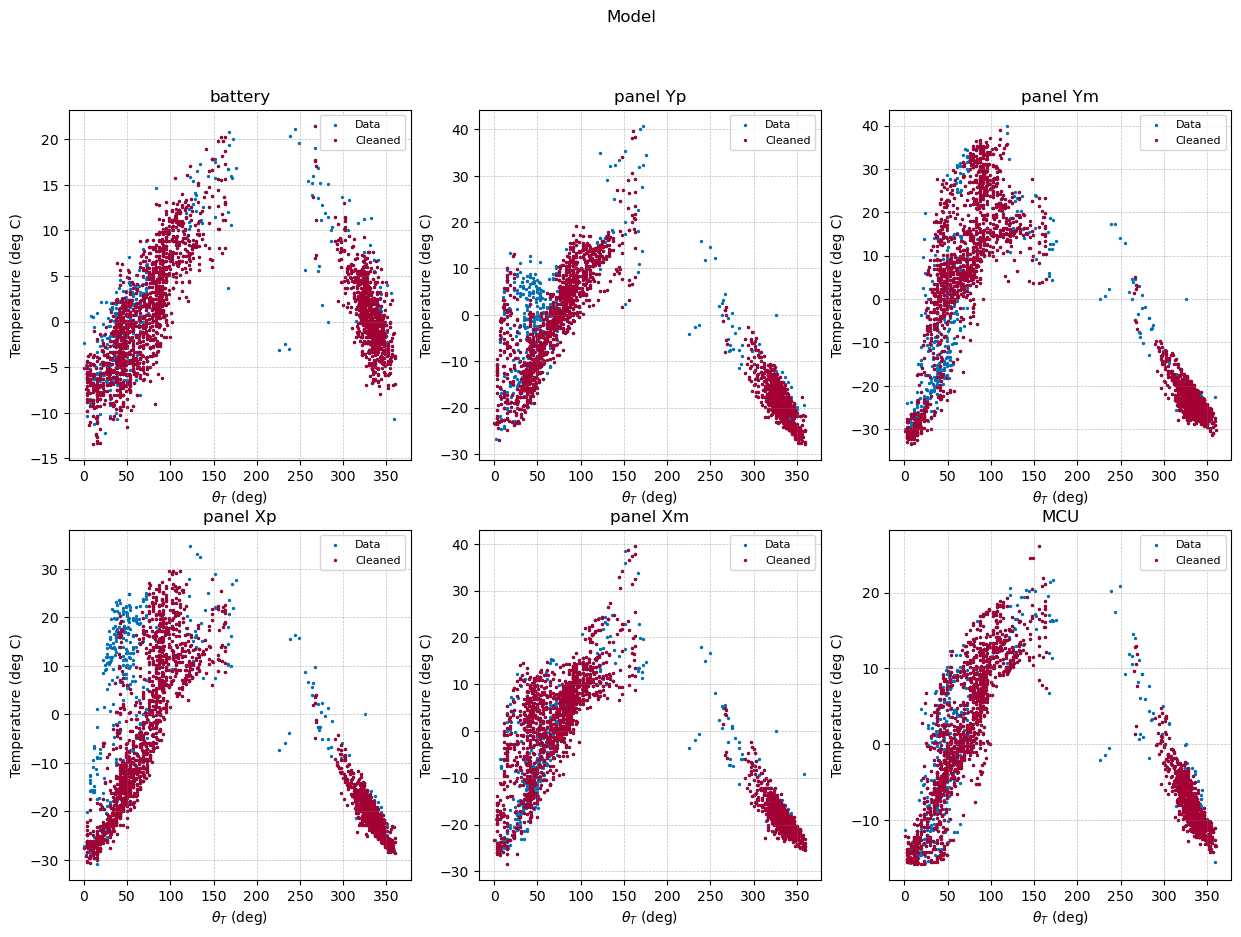

In [12]:
theta_T_vals = [telem_df["theta_T (deg)"], telem_processed_df["theta_T (deg)"]]
temp_vals = [telem_df.iloc[:, -6:].to_numpy(), telem_processed_df.iloc[:, -6:].to_numpy()]

plt_titles = ["battery", "panel Yp", "panel Ym", "panel Xp", "panel Xm", "MCU"]
fig, ax = plot_model(theta_T_vals, temp_vals, plt_suptitle="Model", plt_scatter=[True, True], plt_titles=plt_titles, labels=["Data", "Cleaned"])

In [13]:
# Initializing delfi-pq satellite
POS_INTERP = r"../../orbit-propagation/interpolators/delfi-pq-pos-interpolator-2022-01-18-to-2023-02-05.pkl"
VEL_INTERP = r"../../orbit-propagation/interpolators/delfi-pq-vel-interpolator-2022-01-18-to-2023-02-05.pkl"

delfi_pq = Satellite(POS_INTERP, VEL_INTERP)

Loading interpolators from pickle files...
Interpolators loaded.


In [14]:
def window_data_base_illumination(df, window_size, illumination_data):
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["battery temp"],
        ["solar panel Yp temp"],
        ["solar panel Ym temp"],
        ["solar panel Xp temp"],
        ["solar panel Xm temp"],
        ["MCU temp"]
    ))

    window_df = pd.DataFrame(columns=columns)

    with alive_bar(len(df), theme="classic", force_tty=True) as bar:
        for i, row in df.iterrows():
            window_df.loc[i, "theta_T"] = np.float64(df.loc[i, "theta_T (deg)"])
            window_df.loc[i, "illumination 0":"illumination "+str(window_size-1)] = illumination_data[i, -window_size:]
            window_df.loc[i, "battery temp"] = df.loc[i, "battery TMP20 temperature (deg C)"]
            window_df.loc[i, "solar panel Yp temp"] = df.loc[i, "solar panel Yp temperature (deg C)"]
            window_df.loc[i, "solar panel Ym temp"] = df.loc[i, "solar panel Ym temperature (deg C)"]
            window_df.loc[i, "solar panel Xp temp"] = df.loc[i, "solar panel Xp temperature (deg C)"]
            window_df.loc[i, "solar panel Xm temp"] = df.loc[i, "solar panel Xm temperature (deg C)"]
            window_df.loc[i, "MCU temp"] = df.loc[i, "MCU temperature (deg C)"]
            bar()
            
    x = window_df.iloc[:, 1:-6].to_numpy()
    y = window_df.iloc[:, -6:].to_numpy()

    return window_df, x.reshape(-1, window_size, 1), y

In [22]:
# from functools import cache, lru_cache

# @cache
# def calc_illum(time):
#     beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(time)
#     if theta_T.value < 2 * np.pi * (1 - fe.value):
#         return 1
#     else:
#         return 0
    
# illumination_data = np.zeros(shape=(len(telem_df), 120))
# telem_df = telem_df.reset_index(drop=True)
# with alive_bar(len(telem_df), theme="classic", force_tty=True) as bar:
#     for i, row in telem_df.iterrows():
#         try:
#             time = Time(row["time (utc)"], format="iso", scale="utc")
            
#             for j in range(120):
#                 calc_time = time - (120 - j) * u.min
#                 illum = calc_illum(calc_time)
#                 illumination_data[i, j] = illum
#         except ValueError:
#             illumination_data[i, 0] = np.nan
        
                
#         bar()
        
# np.save("illumination_data.npy", illumination_data)

In [15]:
telem_processed_df = telem_processed_df.reset_index(drop=True)
train_df = telem_processed_df.iloc[:int(0.8*len(telem_processed_df)), :].copy()
test_df = telem_processed_df.iloc[int(0.8*len(telem_processed_df)):, :].copy()

norm_limits = [np.min(train_df.iloc[:, -6:].to_numpy()), np.max(train_df.iloc[:, -6:].to_numpy())]
train_norm_df = train_df.copy(deep=True)
train_norm_df.iloc[:, -7:] = normalize_temperature(train_norm_df.iloc[:, -7:].to_numpy(), norm_limits)
test_norm_df = test_df.copy(deep=True)
test_norm_df.iloc[:, -7:] = normalize_temperature(test_norm_df.iloc[:, -7:].to_numpy(), norm_limits)

base_window_size = 96
base_train_window_df, base_train_x, base_train_y = window_data_base_illumination(train_norm_df, base_window_size, illumination_data)
base_test_window_df, base_test_x, base_test_y = window_data_base_illumination(test_norm_df, base_window_size, illumination_data)

[========================================] 1684/1684 [100%] in 2.8s (611.76/s)                                          
[========================================] 422/422 [100%] in 0.4s (1004.37/s)                                           


In [16]:
base_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
base_model_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
base_model_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
base_model_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

base_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=100,
    restore_best_weights=True,
    min_delta=1e-6
)   # early stopping callback

2023-06-26 11:50:31.341116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 11:50:31.342324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 11:50:31.342706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-26 11:50:31.342977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Epoch 1/2000


2023-06-26 11:50:42.422387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-06-26 11:50:42.737260: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efcac113300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-26 11:50:42.737284: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-06-26 11:50:42.756765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-26 11:50:43.002603: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-26 11:50:43.054142: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - 13s 180ms/step - loss: 0.1543 - mean_absolute_error: 0.3433 - val_loss: 0.0461 - val_mean_absolute_error: 0.1716
Epoch 2/2000
17/17 [==============================] - 1s 71ms/step - loss: 0.0472 - mean_absolute_error: 0.1736 - val_loss: 0.0232 - val_mean_absolute_error: 0.1263
Epoch 3/2000
17/17 [==============================] - 1s 72ms/step - loss: 0.0347 - mean_absolute_error: 0.1530 - val_loss: 0.0197 - val_mean_absolute_error: 0.1170
Epoch 4/2000
17/17 [==============================] - 1s 72ms/step - loss: 0.0242 - mean_absolute_error: 0.1264 - val_loss: 0.0106 - val_mean_absolute_error: 0.0773
Epoch 5/2000
17/17 [==============================] - 1s 72ms/step - loss: 0.0112 - mean_absolute_error: 0.0812 - val_loss: 0.0080 - val_mean_absolute_error: 0.0603
Epoch 6/2000
17/17 [==============================] - 1s 71ms/step - loss: 0.0076 - mean_absolute_error: 0.0635 - val_loss: 0.0085 - val_mean_absolute_error: 0.0647
Epoch 7/2000
17/17 [=

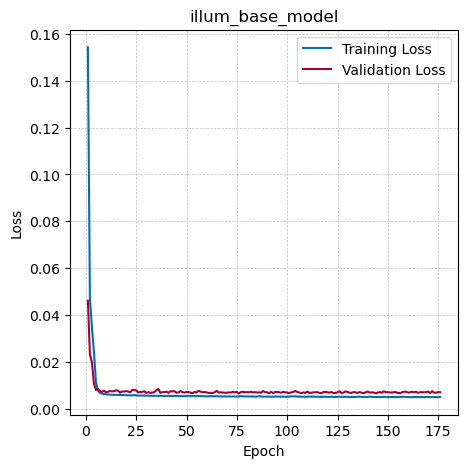

In [17]:
base_model = Model(base_train_x.astype(np.float64), base_train_y.astype(np.float64), base_test_x.astype(np.float64), base_test_y.astype(np.float64), "illum_base_model")
base_model.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)
base_model.train_model(2000, base_early_stopping)
# base_model.train_model(200)

In [18]:
# Creating illumination data for a full orbit
start_time = Time("2022-01-27 18:33:00", format="iso", scale="utc")
end_time = start_time + 94 * u.min

start = delfi_pq.calc_beta_fe_theta(start_time)
end = delfi_pq.calc_beta_fe_theta(end_time)

print(start[3].to(u.deg))
print(end[3].to(u.deg))

# Artificial orbit
artificial_df = pd.DataFrame(columns=base_test_window_df.columns, index=range(95))
time = start_time
with alive_bar(95, theme='classic', force_tty=True) as bar:
    for i in range(95):
        beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(time)
        artificial_df.iloc[i, 0] = theta_T.to(u.deg).value
        for j in range(96):
            calc_time = time - (96 - j) * u.min
            beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(calc_time)
            if theta_T.value < 2 * np.pi * (1 - fe.value):
                artificial_df.loc[i, "illumination " + str(j)] = 1
            else:
                artificial_df.loc[i, "illumination " + str(j)] = 0
        
        time += 1 * u.min

        bar()

1.6760463185902963 deg
357.3887434576583 deg
[========================================] 95/95 [100%] in 1:43.3 (0.92/s)                                              


In [19]:
start_time = Time("2022-01-27 18:33:00", format="iso", scale="utc")
end_time = start_time + 11*94 * u.min

start = delfi_pq.calc_beta_fe_theta(start_time)
end = delfi_pq.calc_beta_fe_theta(end_time)
print(start[3].to(u.deg))
print(end[3].to(u.deg))

1.6760463185902963 deg
314.56610200396955 deg


In [20]:
artificial_x = np.empty(shape=(95, 96, 1), dtype=np.float64)
artificial_x[:, :, 0] = artificial_df.iloc[:, 1:97].to_numpy()

base_preds = denormalize_temperature(base_model.model.predict(artificial_x), norm_limits)

3/3 [==============================] - 3s 17ms/step


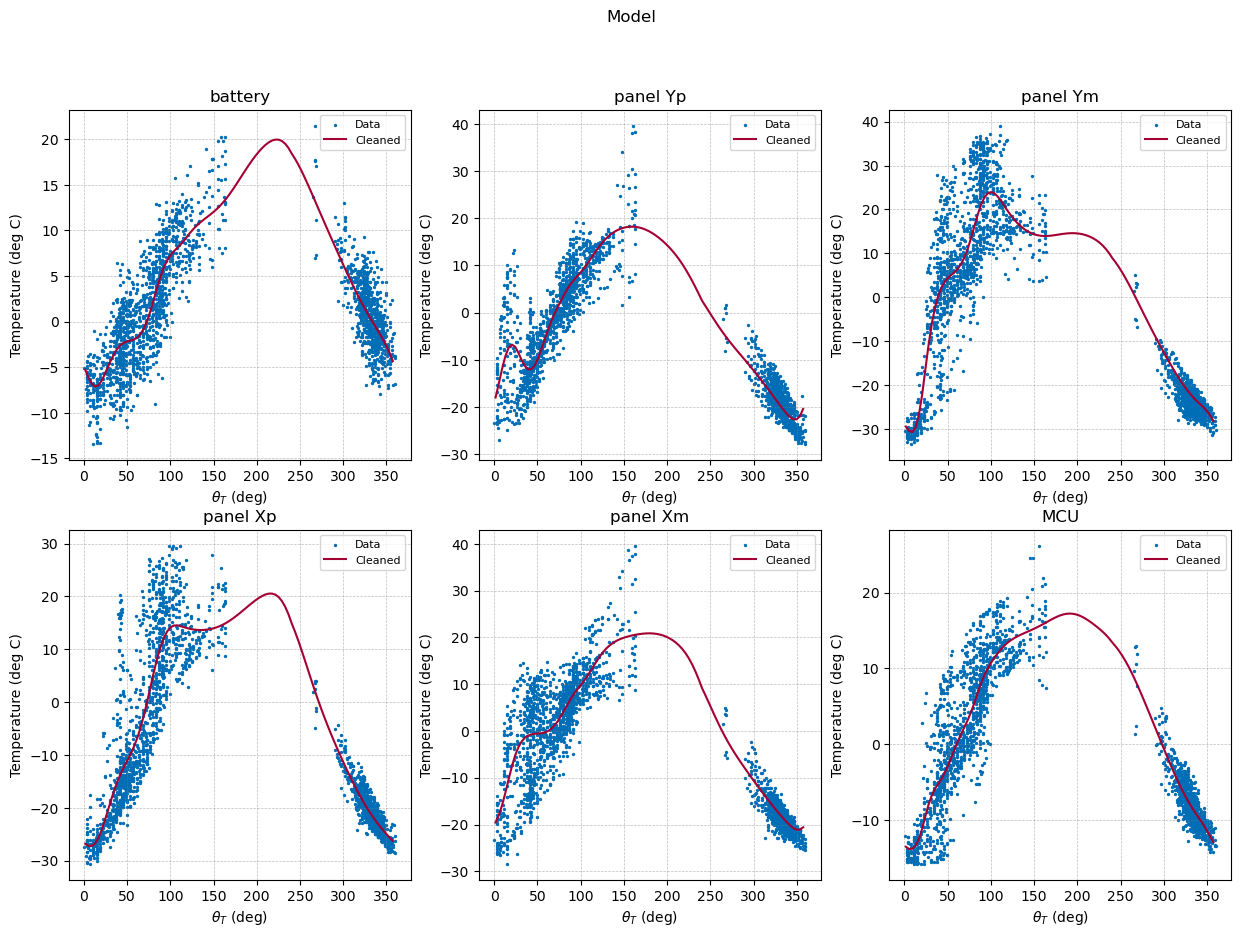

In [21]:
theta_T_vals = [telem_processed_df["theta_T (deg)"], artificial_df["theta_T"]]
temp_vals = [telem_processed_df.iloc[:, -6:].to_numpy(), base_preds]

plt_titles = ["battery", "panel Yp", "panel Ym", "panel Xp", "panel Xm", "MCU"]
fig, ax = plot_model(theta_T_vals, temp_vals, plt_suptitle="Model", plt_scatter=[True, False], plt_titles=plt_titles, labels=["Data", "Cleaned"])

14/14 [==============================] - 0s 23ms/step


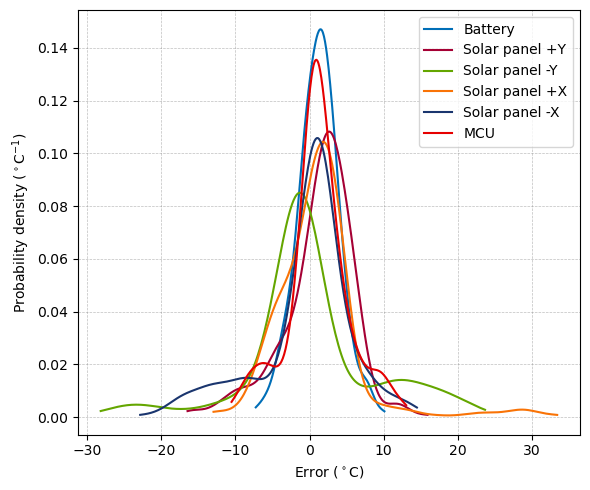

0.7087587541878505
5.797758360538998


In [22]:
actual = denormalize_temperature(test_norm_df.iloc[:, -6:].to_numpy(), norm_limits)
predicted = denormalize_temperature(base_model.model.predict(base_test_x.astype(np.float64)), norm_limits)
errors = actual - predicted
plt_titles = ["Battery", "Solar panel +Y", "Solar panel -Y", "Solar panel +X", "Solar panel -X", "MCU"]
kde_vals, kde_bins = kde(errors, plot_kde=False)
fig, ax =plt.subplots(figsize=(6, 5), tight_layout=True)
for i in range(6):
    ax.plot(kde_bins[i], kde_vals[i], label=plt_titles[i], color=plt_colors[i])
ax.grid()
ax.set_xlabel(r"Error ($^\circ$C)")
ax.set_ylabel(r"Probability density ($^\circ$C$^{-1}$)")
ax.legend()

# fig.savefig(f"../../report/images/chapter-4/delfi-pq-illum-base-kde.pdf")
plt.show()


print(np.nanmean(errors))
print(np.nanstd(errors))

In [23]:
# Checking contiguity of available temperature data:
contiguity_train_df = telem_processed_df.iloc[:int(0.8*len(telem_processed_df))].copy()

# Pass: when subsequent datapoints are within 1 minute of each other
contiguity_train_df["Pass"] = np.nan

pass_no = 0
contiguity_train_df.loc[0, "Pass"] = pass_no
for i in range(1, len(contiguity_train_df)):
    if contiguity_train_df["time (jd)"][i] - contiguity_train_df["time (jd)"][i-1] > 1.1/1440:
        pass_no += 1
    contiguity_train_df.loc[i, "Pass"] = pass_no

pass_train_df = pd.DataFrame(columns=["pass", "count"], index=range(pass_no+1))
for i in range(pass_no+1):
    pass_train_df.loc[i, "pass"] = i
    pass_train_df.loc[i, "count"] = len(contiguity_train_df[contiguity_train_df["Pass"] == i])

count_df = pd.DataFrame(columns=["count", "train no", "test no"], index=range(1, max(pass_train_df["count"])+1))
for i in range(1, max(pass_train_df["count"])+1):
    count_df.loc[i, "count"] = i
    count_df.loc[i, "train no"] = len(pass_train_df[pass_train_df["count"] == i])

contiguity_test_df = test_norm_df.copy().reset_index(drop=True)
contiguity_test_df["Pass"] = np.nan
pass_no = 0
contiguity_test_df.loc[0, "Pass"] = pass_no

for i in range(1, len(contiguity_test_df)):
    if contiguity_test_df["time (jd)"][i] - contiguity_test_df["time (jd)"][i-1] > 1.1/1440:
        pass_no += 1
    contiguity_test_df.loc[i, "Pass"] = pass_no

pass_test_df = pd.DataFrame(columns=["pass", "count"], index=range(pass_no+1))
for i in range(pass_no+1):
    pass_test_df.loc[i, "pass"] = i
    pass_test_df.loc[i, "count"] = len(contiguity_test_df[contiguity_test_df["Pass"] == i])

for i in range(1, max(pass_test_df["count"])+1):
    count_df.loc[i, "test no"] = len(pass_test_df[pass_test_df["count"] == i])

print(count_df)

   count train no test no
1      1      442     139
2      2      223      57
3      3      100      35
4      4       54       8
5      5       19       4
6      6       12       2
7      7        6     NaN
8      8        3     NaN
9      9        3     NaN
10    10        2     NaN


(2486, 13)
(2486, 120)
(2106, 13)
(2106, 120)


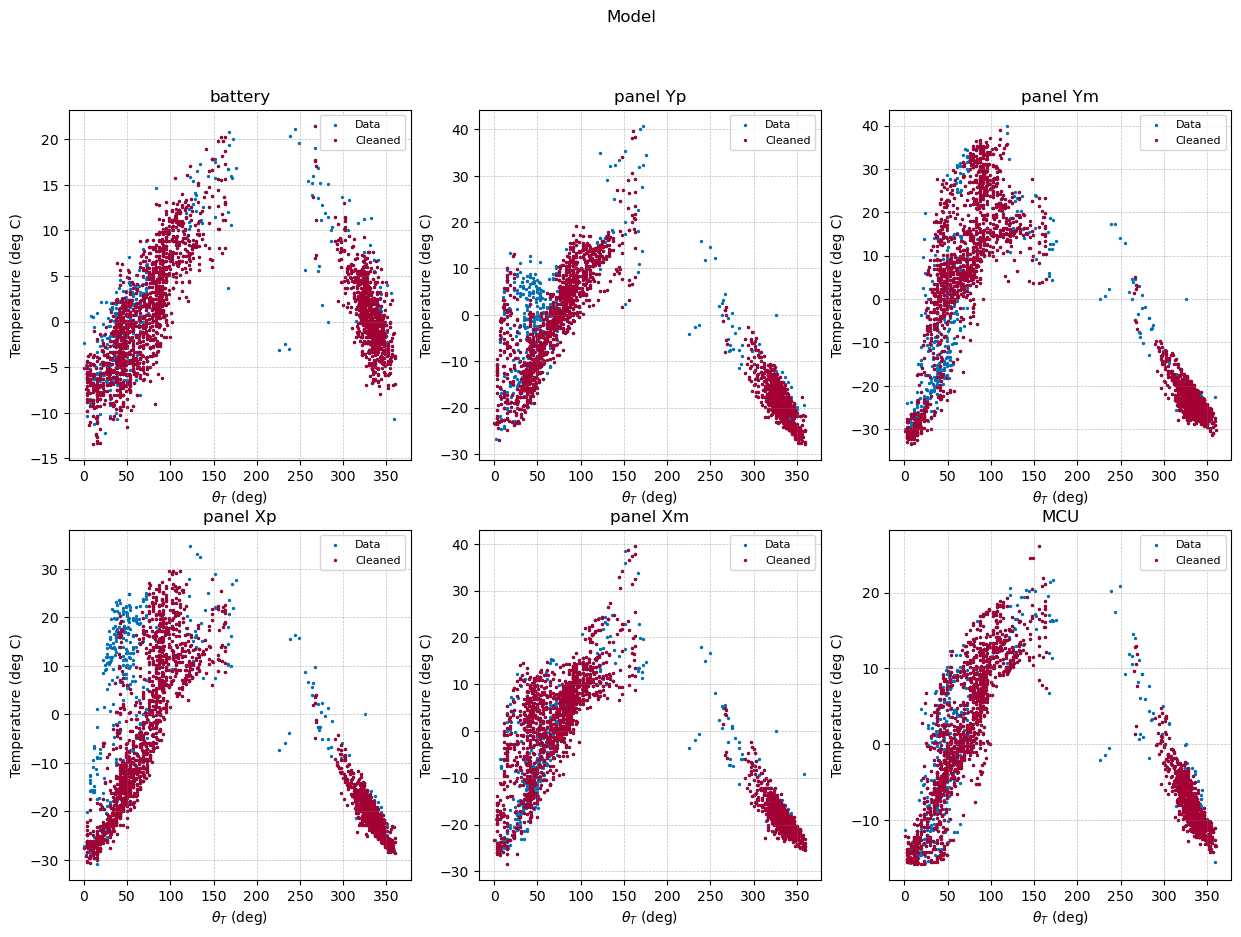

In [24]:
# Full data
# Plotting the temperature data in a violin plot:
# Removing obvious anomalies:
telem_df = telem_raw_df.copy(deep=True)
for i, row in telem_df.iterrows():
    for j, item in row.iloc[6:].items():
        if not -40 < item < 70:
            telem_df.loc[i, j] = np.nan
            
telem_df = telem_df.dropna(how="any")
telem_df = telem_df.iloc[1:, :]


illumination_data = np.load(r"./illumination_data.npy")
illumination_data = illumination_data[1:]


theta_T_window = 5
min_data = 7
telem_processed_df = telem_df.copy(deep=True).reset_index(drop=True)
theta_T_bins = np.arange(0, 360, theta_T_window)
theta_T = telem_processed_df["theta_T (deg)"].to_numpy()

for i in range(7):
    raw_temps = telem_processed_df.iloc[:, 6+i].to_numpy()
    cleaned_temps = raw_temps.copy()
    for theta_T_bin in theta_T_bins:
        idxs = np.where((theta_T >= theta_T_bin) & (theta_T < theta_T_bin + theta_T_window))[0]
        temps = raw_temps[idxs]
        if temps.shape[0] < min_data:
            temps[:] = np.nan
        else:
            temps = hampel_filter(temps)
        cleaned_temps[idxs] = temps
        
    telem_processed_df.iloc[:, 6+i] = cleaned_temps
    
print(telem_processed_df.shape)
print(illumination_data.shape)
# Get indexes of rows containing NaNs
nan_idxs = telem_processed_df.index[telem_processed_df.isna().any(axis=1)].tolist()
# Drop rows containing NaNs and the corresponding illumination data
telem_processed_df = telem_processed_df.dropna(how="any")
illumination_data = np.delete(illumination_data, nan_idxs, axis=0)

print(telem_processed_df.shape)
print(illumination_data.shape)
    
theta_T_vals = [telem_df["theta_T (deg)"], telem_processed_df["theta_T (deg)"]]
temp_vals = [telem_df.iloc[:, -6:].to_numpy(), telem_processed_df.iloc[:, -6:].to_numpy()]

plt_titles = ["battery", "panel Yp", "panel Ym", "panel Xp", "panel Xm", "MCU"]
fig, ax = plot_model(theta_T_vals, temp_vals, plt_suptitle="Model", plt_scatter=[True, True], plt_titles=plt_titles, labels=["Data", "Cleaned"])

In [25]:
telem_processed_df = telem_processed_df.reset_index(drop=True)
train_df = telem_processed_df.iloc[:int(0.8*len(telem_processed_df)), :].copy()
test_df = telem_processed_df.iloc[int(0.8*len(telem_processed_df)):, :].copy()

norm_limits = [np.min(train_df.iloc[:, -6:].to_numpy()), np.max(train_df.iloc[:, -6:].to_numpy())]
train_norm_df = train_df.copy(deep=True)
train_norm_df.iloc[:, -7:] = normalize_temperature(train_norm_df.iloc[:, -7:].to_numpy(), norm_limits)
test_norm_df = test_df.copy(deep=True)
test_norm_df.iloc[:, -7:] = normalize_temperature(test_norm_df.iloc[:, -7:].to_numpy(), norm_limits)

base_window_size = 96
base_train_window_df, base_train_x, base_train_y = window_data_base_illumination(train_norm_df, base_window_size, illumination_data)
base_test_window_df, base_test_x, base_test_y = window_data_base_illumination(test_norm_df, base_window_size, illumination_data)

[                                        ] - 0/1684 [0%] in 0s (~0s, 0.0/s) 

[========================================] 1684/1684 [100%] in 4.9s (344.63/s)                                          
[========================================] 422/422 [100%] in 0.9s (506.77/s)                                            


In [26]:
base_model_full_data = Model(base_train_x.astype(np.float64), base_train_y.astype(np.float64), base_test_x.astype(np.float64), base_test_y.astype(np.float64), "illum_base_model")
base_model_full_data.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)
base_model_full_data.train_model(2000, monitor_val_loss=False, batch_size=512)
# base_model_full_data.train_model(200)

Epoch 1/2000
4/4 [==============================] - 17s 184ms/step - loss: 0.2007 - mean_absolute_error: 0.4035
Epoch 2/2000
4/4 [==============================] - 1s 185ms/step - loss: 0.1809 - mean_absolute_error: 0.3772
Epoch 3/2000
4/4 [==============================] - 1s 187ms/step - loss: 0.1554 - mean_absolute_error: 0.3376
Epoch 4/2000
4/4 [==============================] - 1s 181ms/step - loss: 0.1248 - mean_absolute_error: 0.2919
Epoch 5/2000
4/4 [==============================] - 1s 183ms/step - loss: 0.0963 - mean_absolute_error: 0.2579
Epoch 6/2000
4/4 [==============================] - 1s 184ms/step - loss: 0.0759 - mean_absolute_error: 0.2243
Epoch 7/2000
4/4 [==============================] - 1s 186ms/step - loss: 0.0585 - mean_absolute_error: 0.1904
Epoch 8/2000
4/4 [==============================] - 1s 186ms/step - loss: 0.0498 - mean_absolute_error: 0.1667
Epoch 9/2000
4/4 [==============================] - 1s 182ms/step - loss: 0.0435 - mean_absolute_error: 0.1624


KeyboardInterrupt: 

3/3 [==============================] - 2s 13ms/step


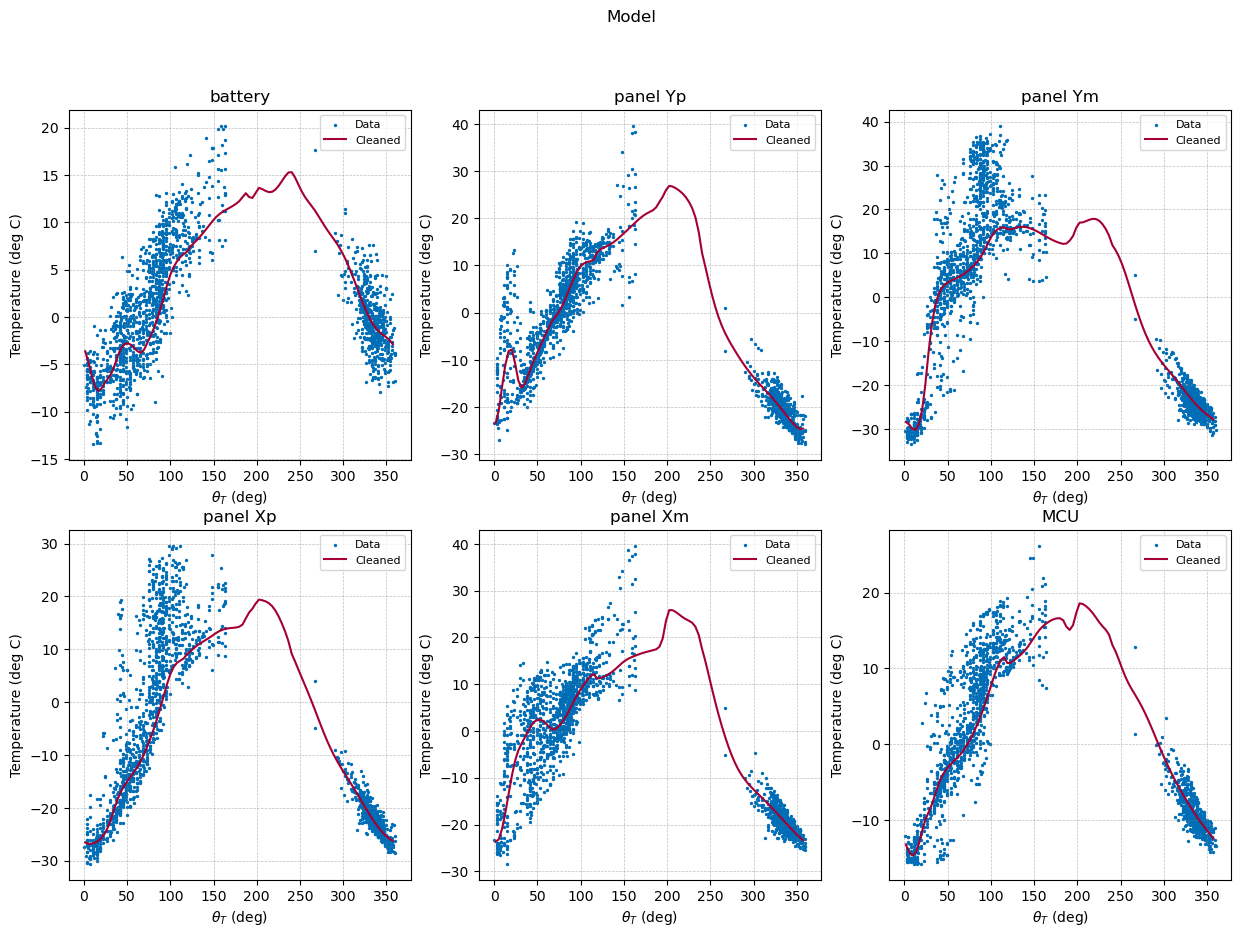

In [ ]:
artificial_x = np.empty(shape=(95, 96, 1), dtype=np.float64)
artificial_x[:, :, 0] = artificial_df.iloc[:, 1:97].to_numpy()

base_preds = denormalize_temperature(base_model_full_data.model.predict(artificial_x), norm_limits)

theta_T_vals = [train_norm_df["theta_T (deg)"], artificial_df["theta_T"]]
temp_vals = [denormalize_temperature(train_norm_df.iloc[:, -6:].to_numpy(), norm_limits), base_preds]

plt_titles = ["battery", "panel Yp", "panel Ym", "panel Xp", "panel Xm", "MCU"]
fig, ax = plot_model(theta_T_vals, temp_vals, plt_suptitle="Model", plt_scatter=[True, False], plt_titles=plt_titles, labels=["Data", "Cleaned"])

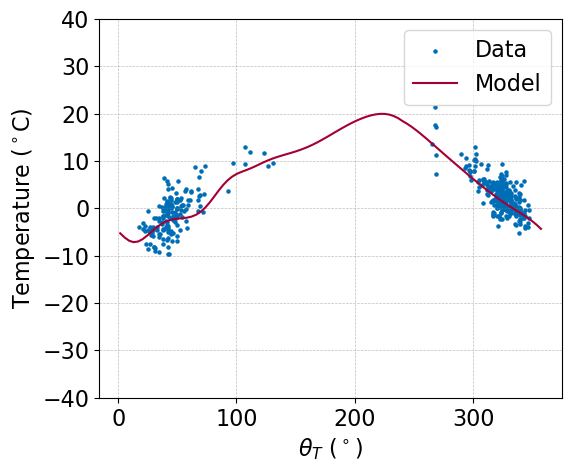

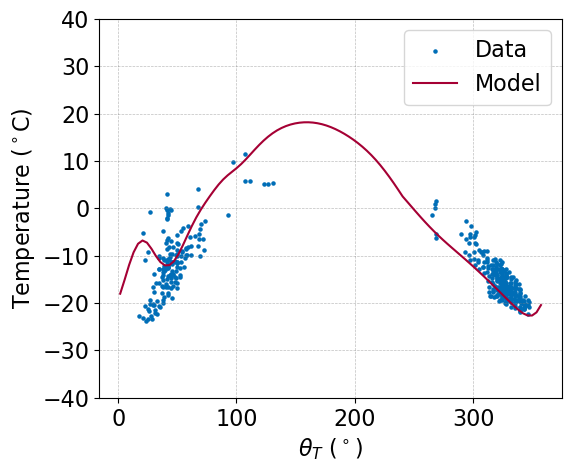

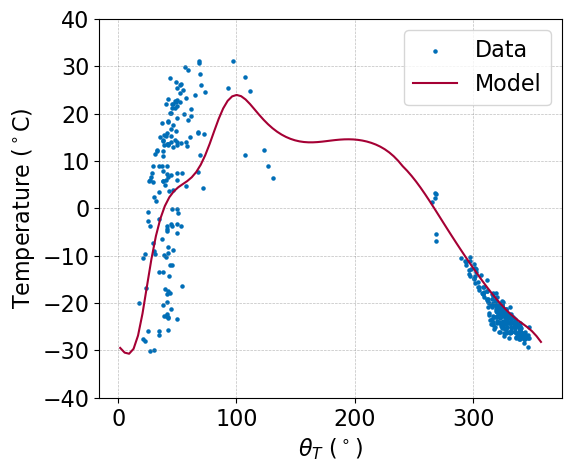

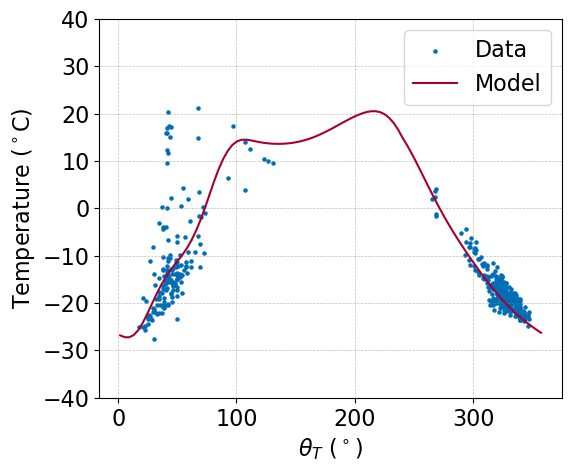

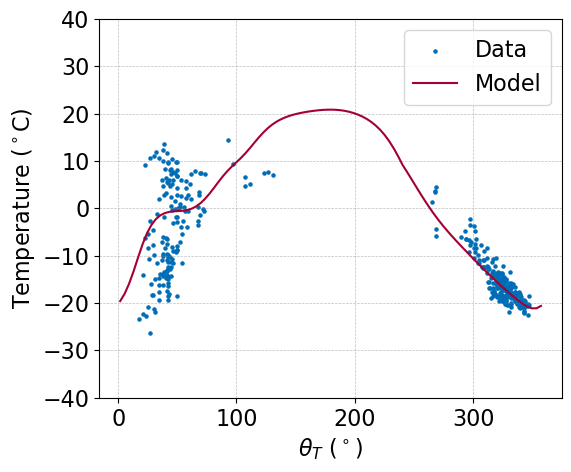

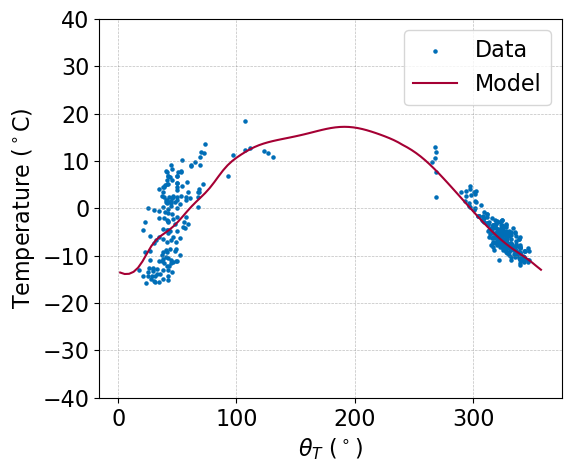

In [28]:
plt_titles = ["battery", "panel-Yp", "panel-Ym", "panel-Xp", "panel-Xm", "MCU"]
plt.rcParams.update({"font.size": 16})
for i in range(6):
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.scatter(test_norm_df["theta_T (deg)"], denormalize_temperature(test_norm_df.iloc[:, -6:].to_numpy(), norm_limits)[:, i], label="Data", s=5, color=plt_colors[0])
    ax.plot(artificial_df["theta_T"], base_preds[:, i], label="Model", color=plt_colors[1])
    ax.grid()
    ax.set_xlabel(r"$\theta_T$ ($^\circ$)")
    ax.set_ylabel(r"Temperature ($^\circ$C)")
    ax.set_ylim([-40, 40])
    ax.legend()
    
    fig.savefig(f"../../report/images/chapter-4/delfi-pq-illum-base-{plt_titles[i]}.pdf")

14/14 [==============================] - 0s 17ms/step


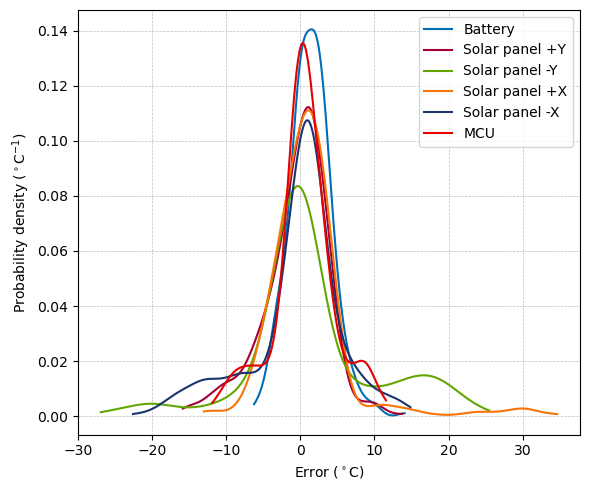

In [ ]:
actual = denormalize_temperature(test_norm_df.iloc[:, -6:].to_numpy(), norm_limits)
predicted = denormalize_temperature(base_model_full_data.model.predict(base_test_x.astype(np.float64)), norm_limits)
errors = actual - predicted
plt_titles = ["Battery", "Solar panel +Y", "Solar panel -Y", "Solar panel +X", "Solar panel -X", "MCU"]
kde_vals, kde_bins = kde(errors, plot_kde=False)
fig, ax =plt.subplots(figsize=(6, 5), tight_layout=True)
for i in range(6):
    ax.plot(kde_bins[i], kde_vals[i], label=plt_titles[i], color=plt_colors[i])
ax.grid()
ax.set_xlabel(r"Error ($^\circ$C)")
ax.set_ylabel(r"Probability density ($^\circ$C$^{-1}$)")
ax.legend()

# fig.savefig(f"../../report/images/chapter-4/delfi-pq-illum-base-kde.pdf")
plt.show()


[ 5.77499459 12.98953679 20.68637514 16.46046114 13.48218345  9.45549275]


In [60]:
months = np.arange(1, 10)
std = np.zeros((len(months), 6), dtype=np.float64)
theta_T_bins = np.arange(0, 360, 5)

for i, month in enumerate(months):
    init_time = train_df["time (jd)"].iloc[0]
    data_slice = train_df[train_df["time (jd)"] < init_time + month*30]
    std_slice = np.zeros((len(theta_T_bins), 6), dtype=np.float64) * np.nan
    for j, theta_T_bin in enumerate(theta_T_bins):
        std_slice[i, :] = np.nanstd(data_slice[data_slice["theta_T (deg)"] > theta_T_bin & (data_slice["theta_T (deg)"] < theta_T_bin + 5)].iloc[:, -6:].to_numpy(), axis=0)
        
    std[i, :] = np.nanmean(std_slice, axis=0)